# Weather Impact on Agricultural Commodity Prices

Importing necessary libraries:

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

Add root directory to PATH:

In [2]:
module_path = Path().cwd().parent.as_posix()
if module_path not in sys.path:
    sys.path.append(module_path)

Importing custom functions and modules:

In [3]:
from src.price import get_commodity_data
from src.noaa import noaa_batch_data_extraction
from src.nasa import nasa_batch_data_extraction
from src.utils import load_price, data_prep
from src.data_prep import preprocess_data, save_cleaned_data
from src.data_viz import plot_time_series, plot_spectral_analysis, plot_ecm_adjustment
from src.analysis import test_stationarity, fit_arima_model, error_correction_model, regression_model, create_regression_table, rolling_window_validation

Autoreload on update:

In [4]:
%load_ext autoreload
%autoreload 2

Load environment variables from .env file:

In [5]:
load_dotenv(override=True)

True

Define and create (if not exists) data folder:

In [6]:
DATA_FOLDER = Path().cwd().parent / 'data'
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

Define research time span:

In [7]:
START, END = "2010-01-01", "2025-01-01"

## Step 4: Exploratory Data Analysis

Let's perform EDA for the first set of commodities along with corresponding weather data (NASA POWER data are used as they are more reliable):
- commodity: `Lean Hogs`
- closely related product: `Live Cattle`
- tickers: `HE=F`, `LE=F`
- main production states: `Iowa`, `Illinois`, `Nebraska`
- weather data privider: `NASA POWER`

In [33]:
# Load tickers dictionary.
with open(Path.cwd().parent / 'lib' / 'tickers.json', 'r') as fp:
    TICKERS = json.load( fp)

# Define states.
states = ['Iowa', 'North_Carolina', 'Minnesota']

# Load and concatenate data.
pork_data = data_prep(
    comoddities=list(TICKERS.keys())[-4:-2],
    states=states,
    tickers_dict=TICKERS,
    data_folder=DATA_FOLDER,
    data_provider='nasa'
).set_index('date')

pork_data.index = pd.to_datetime(pork_data.index)

NB: For tha sake of reusability of `preprocesss_data` function we are gonna rename `lean hogs` to `meat` and `live cattle` to `meat_oil`.

In [34]:
pork_data = pork_data.rename(columns={'lean_hogs': 'meat', 'live_cattle': 'meat_oil'})

Preprocessing data by removing ouliers and filling missing values:

In [35]:
cleaned_df, metadata = preprocess_data(df=pork_data, states=list(map(str.lower, states)), commodity='meat')

Starting data preprocessing...
Missing values summary:
  meat_oil: 0.16% missing
  meat: 0.13% missing
  iowa_tmin: 0.00% missing
  iowa_tmax: 0.00% missing
  iowa_prc: 0.00% missing
  north_carolina_tmax: 0.00% missing
  north_carolina_tmin: 0.00% missing
  north_carolina_prc: 0.00% missing
  minnesota_tmax: 0.00% missing
  minnesota_tmin: 0.00% missing
  minnesota_prc: 0.00% missing
Processing column: meat_oil
Winsorized 1 outliers in meat_oil
Processing column: meat
Winsorized 0 outliers in meat
Processing column: iowa_tmin
Winsorized 2 outliers in iowa_tmin
Processing column: iowa_tmax
Winsorized 1 outliers in iowa_tmax
Processing column: iowa_prc
Winsorized 115 outliers in iowa_prc
Processing column: north_carolina_tmax
Winsorized 4 outliers in north_carolina_tmax
Processing column: north_carolina_tmin
Winsorized 6 outliers in north_carolina_tmin
Processing column: north_carolina_prc
Winsorized 118 outliers in north_carolina_prc
Processing column: minnesota_tmax
Winsorized 1 outli

Saving data:

In [38]:
save_cleaned_data(cleaned_df, metadata, DATA_FOLDER / 'analysis' / 'cleaned', 'pork')

Saved cleaned data to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/pork_weather_cleaned.parquet
Saved metadata saved to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/cleaned/pork_weather_cleaned_metadata.json


First, let's look at commodity price spread depending on the waether anomalies:

Saved time series plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/time_series_meat_spread_north_carolina_temp_anomaly_30d.png


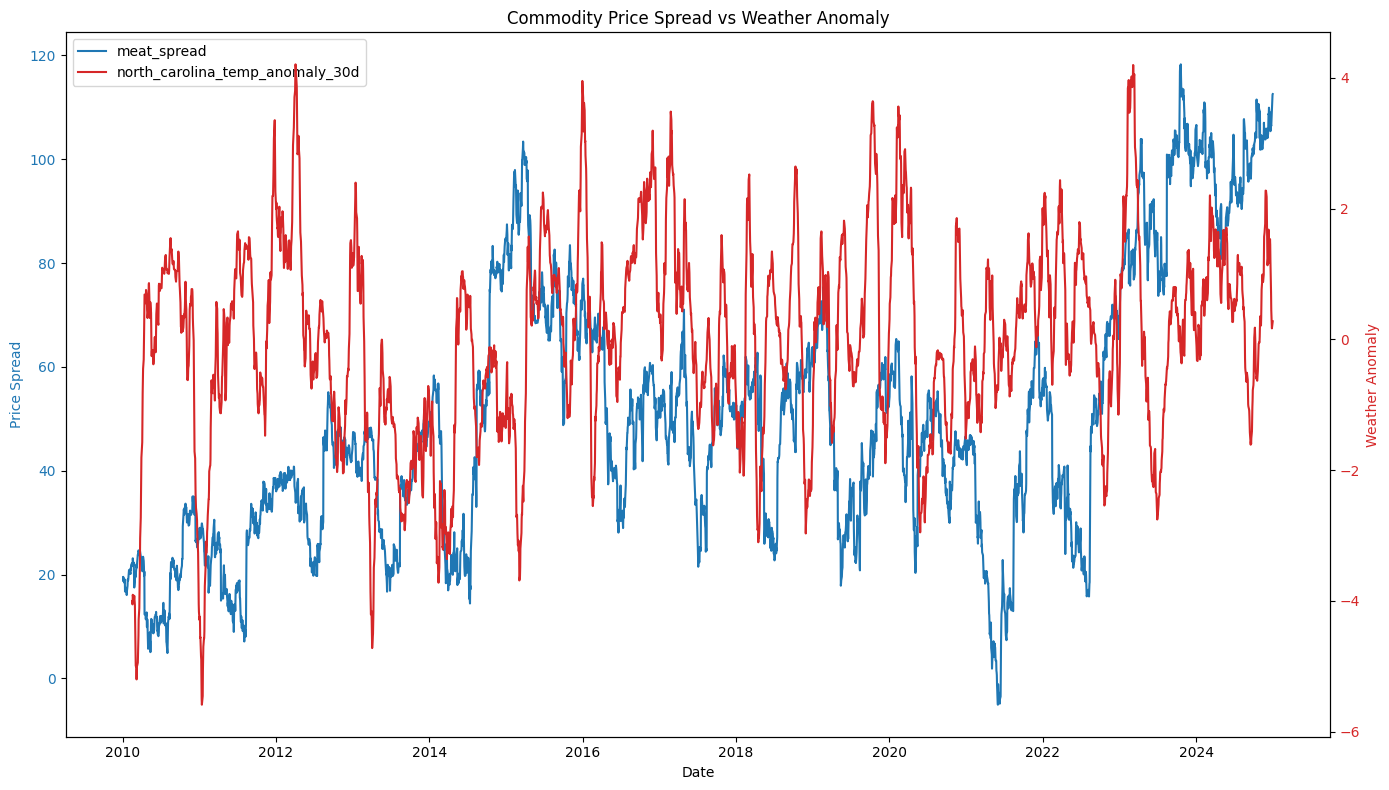

In [39]:
plot_time_series(df=cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', spread_col='meat_spread', anomaly_col='north_carolina_temp_anomaly_30d')

Now let's plot spectral analysis for pork data as well:

Saved spectral analysis plot to /Users/ivan_andriushin/PycharmProjects/MScFECapstone/data/analysis/results/spectral_analysis_meat_spread.png


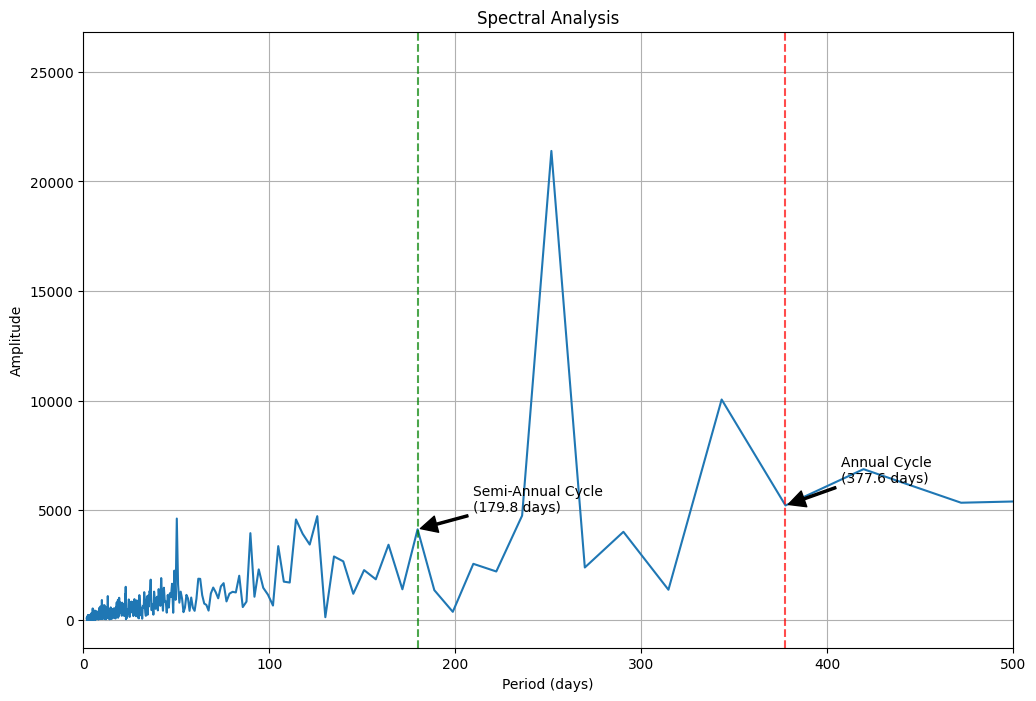

Top 5 dominant periods for meat_spread: [ 944.         1258.66666667  251.73333333 3776.         1888.        ] days


In [40]:
dominant_periods = plot_spectral_analysis(cleaned_df, data_folder=DATA_FOLDER / 'analysis' / 'results', column='meat_spread')

Lean‐hog vs. live‐cattle spread shows a strong ~8-month swing, with a secondary one aroun 11-month (annual) cycle and only a very small half-year signal. Therefore in any seasonal arbitrage or hedge‐adjustment strategy a particular attention should be paid to that 250-day seasonality.

## Step 5: Time Series Analysis

First of all we check time series stationarity wuth Augmented Dickey-Fuller test:

In [41]:
for col in ['meat', 'meat_oil']:
    if col in cleaned_df.columns:
        print(f"\nStationarity Test for {col}:")
        test_stationarity(cleaned_df[col])


Stationarity Test for meat:
ADF Statistic: -3.9531
p-value: 0.0017
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is stationary (p-value <= 0.05)

Stationarity Test for meat_oil:
ADF Statistic: -1.1755
p-value: 0.6840
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)


Then apply ARIMA model for corn data:

In [42]:
# Fit ARIMA model for corn spread.
if 'meat_spread' in cleaned_df.columns:
    arima_model = fit_arima_model(cleaned_df['meat_spread'])

ADF Statistic: -2.3445
p-value: 0.1580
Critical Values:
	1%: -3.4321
	5%: -2.8623
	10%: -2.5672
Series is non-stationary (p-value > 0.05)
Series is not stationary, differencing will be applied
Best ARIMA order: (5, 1, 2) with AIC: 16934.1972
ARIMA Model Summary for meat_spread:
                               SARIMAX Results                                
Dep. Variable:            meat_spread   No. Observations:                 3776
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -8459.099
Date:                Sun, 08 Jun 2025   AIC                          16934.197
Time:                        23:45:10   BIC                          16984.086
Sample:                             0   HQIC                         16951.934
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

Now let's perform cointegration analysis:


Cointegration Analysis for Lean Hogs and Live Cattle:
Johansen Cointegration Test for ['meat', 'meat_oil']:
Trace Statistics:
 [17.17261632  1.84686553]
Critical Values (5%): [15.4943  3.8415]
Cointegration Rank: 1

Vector Error Correction Model (VAR on diffs) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     23:49:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.00089
Nobs:                     3774.00    HQIC:                   1.99450
Log likelihood:          -14461.1    FPE:                    7.32267
AIC:                      1.99098    Det(Omega_mle):         7.31104
--------------------------------------------------------------------
Results for equation meat
                 coefficient       std. error           t-stat            prob
-----------------------------------

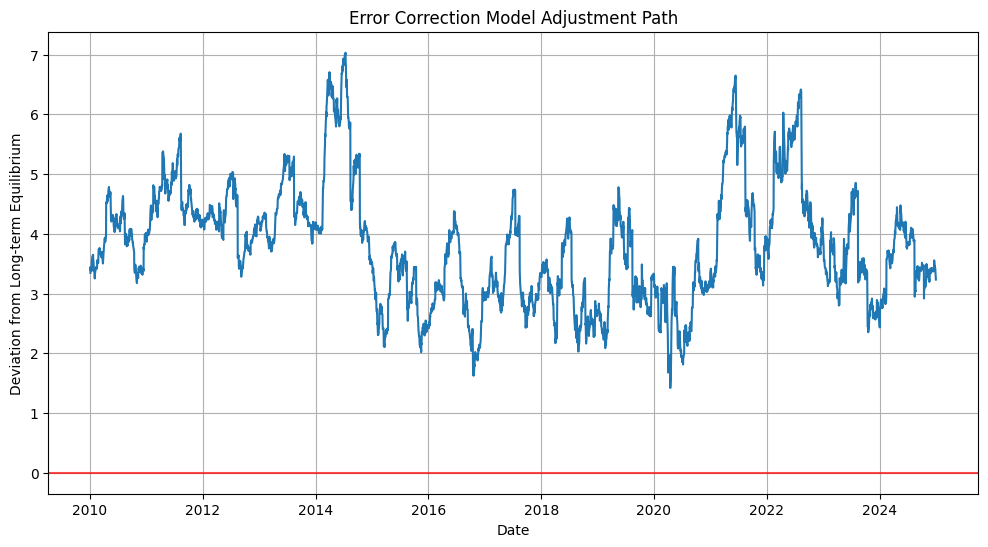

In [44]:
# Cointegration and error correction model
if all(col in cleaned_df.columns for col in ['meat', 'meat_oil']):
    print("\nCointegration Analysis for Lean Hogs and Live Cattle:")
    var_results, ec_series = error_correction_model(cleaned_df, ['meat', 'meat_oil'])

    if ec_series is not None:
        plot_ecm_adjustment(cleaned_df, DATA_FOLDER / 'analysis' / 'results', ec_series, commodity='pork')

As for the soybean and soybean oil the ECM results suggest a cointegrating relationship between for lean hogs and live cattle, with the error correction term to be positive.

## Step 6: Regression Analysis

Let's perform regression analysis:

After searching for best set of independent variables to fit to the model we come to a conclusion that:
1) 'north_carolina_temp_anomaly_30d', 'north_carolina_prc_anomaly_30d', 'minnesota_temp_anomaly_30d' - show the most impact on target variable while being statistically significant; it is worth noting that one of the states weather parameters haven't shwown statistical significance at all (Iowa);
2) weather conditions in the states under consideration, whow very low impact on lean hogs and live cattle prices - only around 3% of variance can be described by weather anomalies.

In [49]:
# Regression analysis with weather variables.
if 'meat_spread' in cleaned_df.columns:
    # Define weather variables.
    # weather_vars = [col for col in cleaned_df.columns if 'anomaly' in col]
    weather_vars = ['north_carolina_temp_anomaly_30d', 'north_carolina_prc_anomaly_30d', 'minnesota_temp_anomaly_30d']

    if weather_vars:
        print("\nRegression Analysis of Price Spread vs Weather Anomalies:")
        reg_results, coef_df = regression_model(cleaned_df, 'meat_spread', weather_vars, lags=0)
        create_regression_table(reg_results, DATA_FOLDER / 'analysis' / 'results', filename='pork_regression_results.csv')

        # Validation.
        print("\nPerforming Rolling Window Validation:")
        validation_df, avg_metrics = rolling_window_validation(cleaned_df, DATA_FOLDER / 'analysis' / 'results', 'meat_spread', weather_vars, filename='pork_validation_results.csv')


Regression Analysis of Price Spread vs Weather Anomalies:
Regression Model for meat_spread:
                            OLS Regression Results                            
Dep. Variable:            meat_spread   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     39.69
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           3.03e-25
Time:                        23:55:36   Log-Likelihood:                -17369.
No. Observations:                3747   AIC:                         3.475e+04
Df Residuals:                    3743   BIC:                         3.477e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------